In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
import cv2
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from glob import glob
import PIL
from PIL import Image

In [ ]:
# Read and examine metadata
data = pd.read_csv('drive/MyDrive/covid-19-segmentation/input/covid19-ct-scans/metadata.csv')
data.sample(5)
data.head(3)

ct_scan  ...                            lung_and_infection_mask
0  /content/drive/MyDrive/covid-19-segmentation/i...  ...  /content/drive/MyDrive/covid-19-segmentation/i...
1  /content/drive/MyDrive/covid-19-segmentation/i...  ...  /content/drive/MyDrive/covid-19-segmentation/i...
2  /content/drive/MyDrive/covid-19-segmentation/i...  ...  /content/drive/MyDrive/covid-19-segmentation/i...

[3 rows x 4 columns]

## ResNet & MaskNet Segmentation Model-  Based on Region and Boundary loss for COVID detection



## Reading dataset

In [ ]:
def read_nii_without_rotation(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.array(array)
    return(array)

In [ ]:
# Read sample
sample_ct   = read_nii_without_rotation(data.loc[0,'ct_scan'])
sample_lung = read_nii_without_rotation(data.loc[0,'lung_mask'])
sample_infe = read_nii_without_rotation(data.loc[0,'infection_mask'])
sample_all  = read_nii_without_rotation(data.loc[0,'lung_and_infection_mask'])

In [ ]:
sample_all.shape

(512, 512, 301)

In [ ]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')

    plt.subplot(1,4,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
    plt.title('Lung and Infection Mask')

    plt.show()

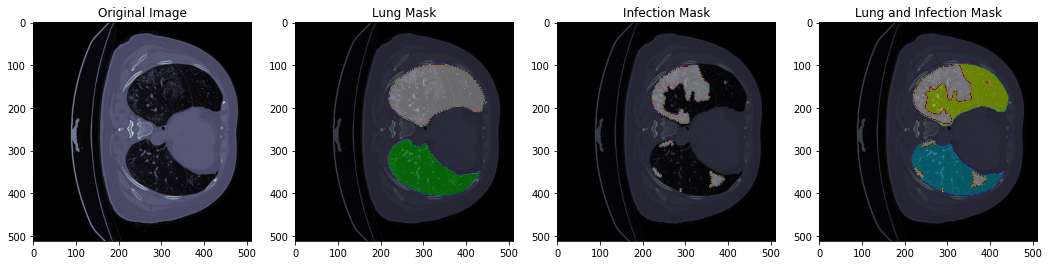

In [ ]:
# Examine one slice of a ct scan and its annotations
plot_sample([sample_ct[...,120], sample_lung[...,120], sample_infe[...,120], sample_all[...,120]])

In [ ]:
# nii ->  neuroimaging
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array)) #this data needs to rotate 90 degrees 
    return(array)

In [ ]:
# Read sample
sample_ct   = read_nii(data.loc[0,'ct_scan'])
sample_lung = read_nii(data.loc[0,'lung_mask'])
sample_infe = read_nii(data.loc[0,'infection_mask'])
sample_all  = read_nii(data.loc[0,'lung_and_infection_mask'])

In [ ]:
sample_ct.shape

(512, 512, 301)

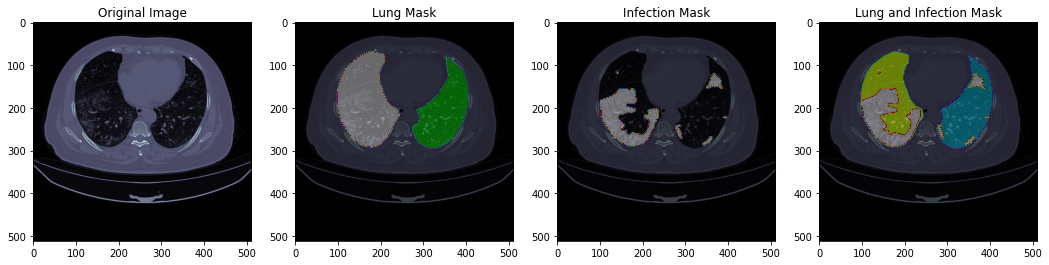

In [ ]:
# Examine one slice of a ct scan and its annotations
plot_sample([sample_ct[...,120], sample_lung[...,120], sample_infe[...,120], sample_all[...,120]])

In [ ]:
def bulk_plot_sample(array_list, index_list):
    '''
    Plots multiple slices, wrapper of plot_sample
    '''
    for index_value in index_list:
        plot_sample([array_list[0][...,index_value], array_list[1][...,index_value], array_list[2][...,index_value], array_list[3][...,index_value]])

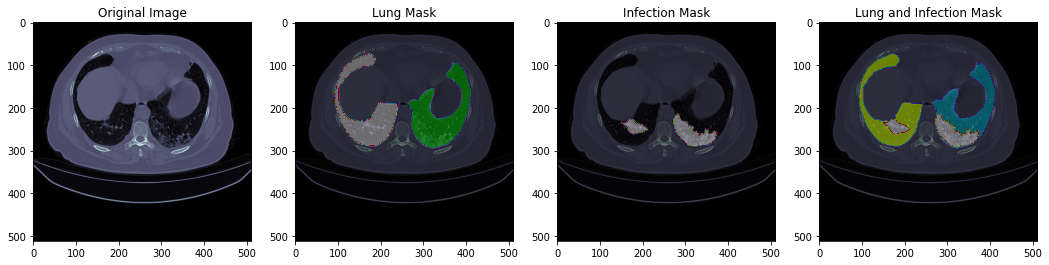

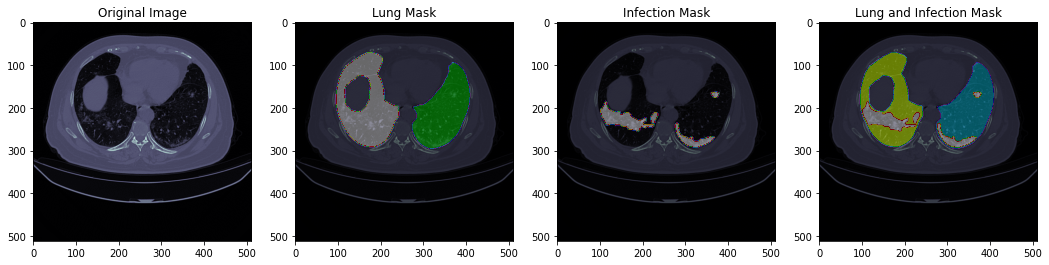

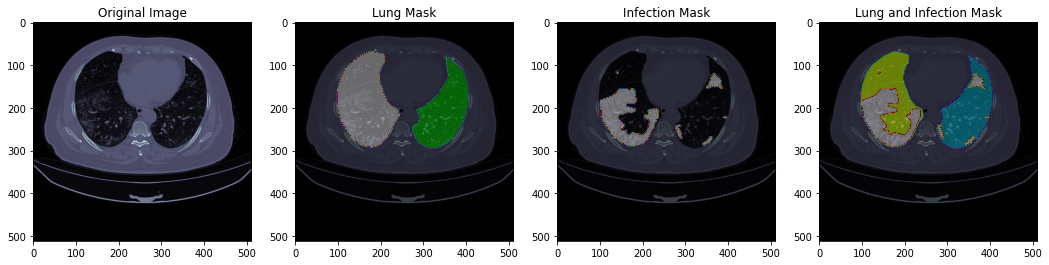

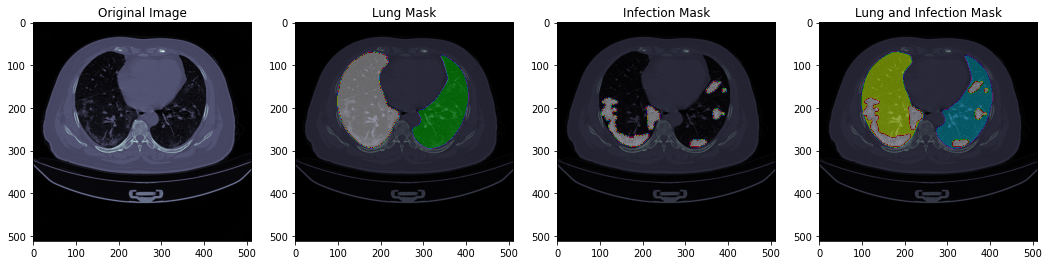

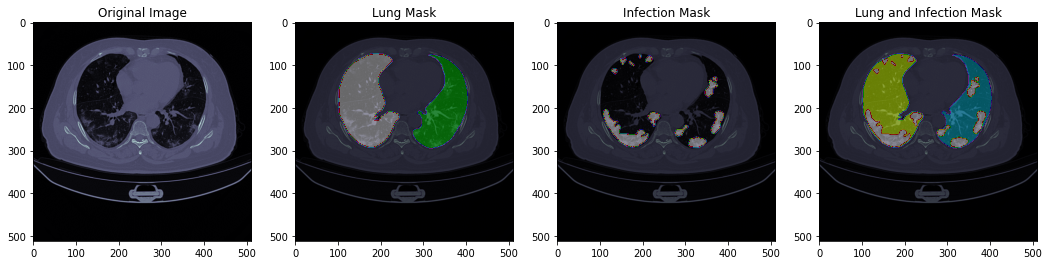

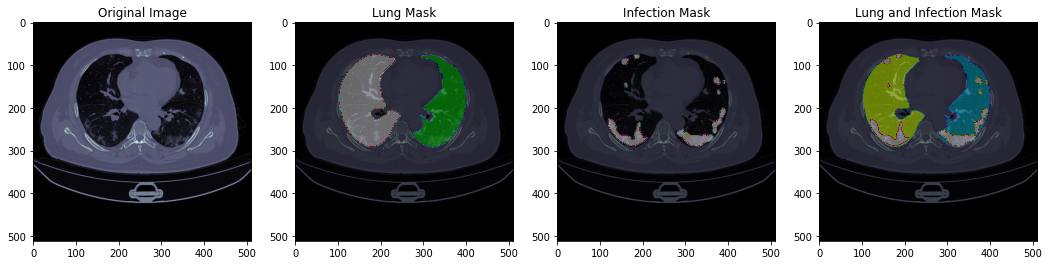

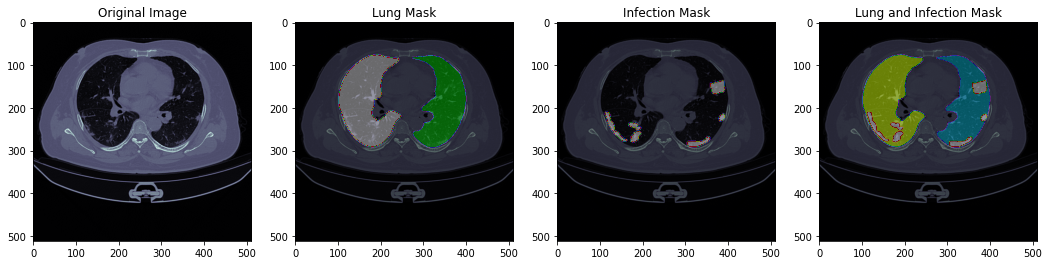

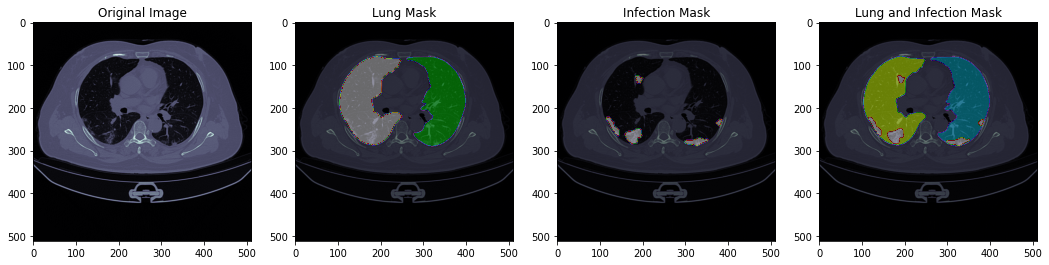

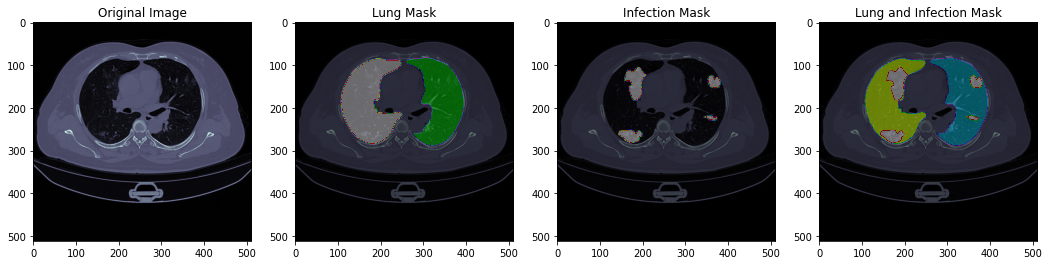

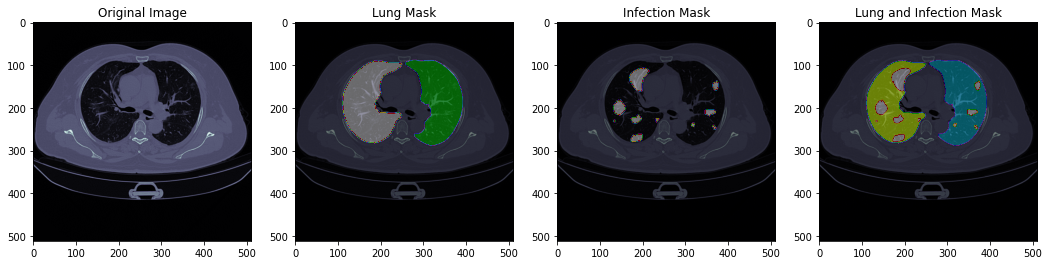

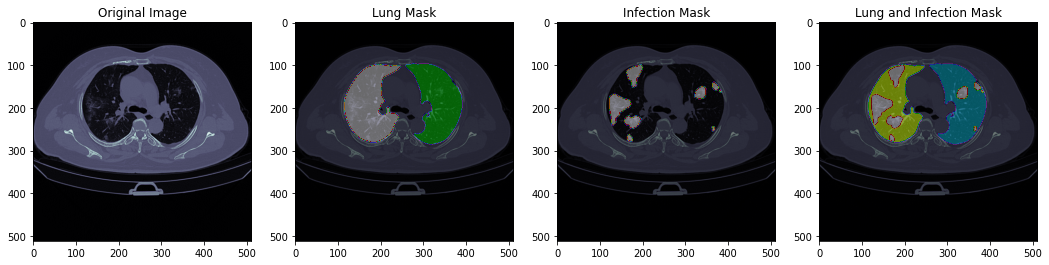

In [ ]:
# Examine multiple slices of a ct scan and its annotations
bulk_plot_sample([sample_ct, sample_lung, sample_infe, sample_all], index_list=[100,110,120,130,140,150,160,170,180,190,200])

In [ ]:
k = 19
sample_ct   = read_nii(data.loc[k,'ct_scan'])
sample_lung = read_nii(data.loc[k,'lung_mask'])
sample_infe = read_nii(data.loc[k,'infection_mask'])
sample_all  = read_nii(data.loc[k,'lung_and_infection_mask'])

In [ ]:
print(sample_ct.shape)
print(sample_lung.shape)
print(sample_infe.shape)
print(sample_all.shape)

(630, 630, 45)
(630, 630, 45)
(630, 630, 45)
(630, 630, 45)


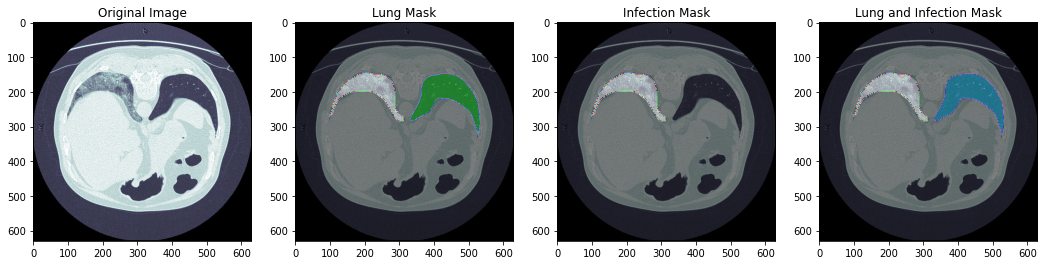

Text(0.5, 1.0, 'Lung and Infection Mask')

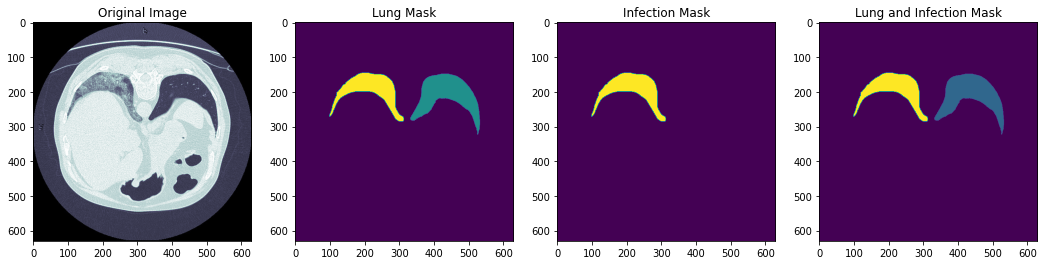

In [ ]:
n =sample_all.shape[2] % 2
n = 40

fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., n], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., n], cmap = 'bone')
plt.imshow(sample_lung[..., n],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sample_ct[..., n], cmap = 'bone')
plt.imshow(sample_infe[..., n], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_ct[..., n], cmap = 'bone')
plt.imshow(sample_all[..., n], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')

plt.show()


fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., n], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)

plt.imshow(sample_lung[..., n])
plt.title('Lung Mask')

plt.subplot(1,4,3)

plt.imshow(sample_infe[..., n])
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_all[..., n])
plt.title('Lung and Infection Mask')

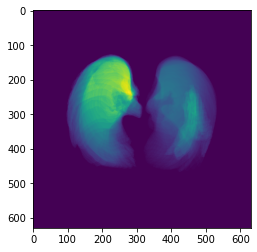

[128  96] [468 531]
2 (109511,) (109511,)


In [ ]:
dd = sample_all[:,:,:].sum(axis=2)
plt.imshow(dd/sample_all.shape[2])
plt.show()

d_size_interes = np.where(dd > 0)
print(np.min(d_size_interes,axis=1),np.max(d_size_interes,axis=1))
print(len(d_size_interes),d_size_interes[0].shape,d_size_interes[1].shape)

## Initialize Mask-Net Segmentation

In [ ]:
# Read and examine metadata
select_model = "masknet"
data = pd.read_csv('drive/MyDrive/covid-19-segmentation/input/covid19-ct-scans/metadata.csv')
data.sample(5)
data.head(3)

ct_scan  ...                            lung_and_infection_mask
0  /content/drive/MyDrive/covid-19-segmentation/i...  ...  /content/drive/MyDrive/covid-19-segmentation/i...
1  /content/drive/MyDrive/covid-19-segmentation/i...  ...  /content/drive/MyDrive/covid-19-segmentation/i...
2  /content/drive/MyDrive/covid-19-segmentation/i...  ...  /content/drive/MyDrive/covid-19-segmentation/i...

[3 rows x 4 columns]

In [ ]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Lung Mask')

    plt.subplot(1,4,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.title('Infection Mask')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
    plt.title('Lung and Infection Mask')

    plt.show()

In [ ]:
from nibabel.testing import data_path

example_filename = 'drive/MyDrive/covid-19-segmentation/input/covid19-ct-scans/ct_scans/coronacases_org_008.nii'

In [ ]:
img = nib.load(example_filename)

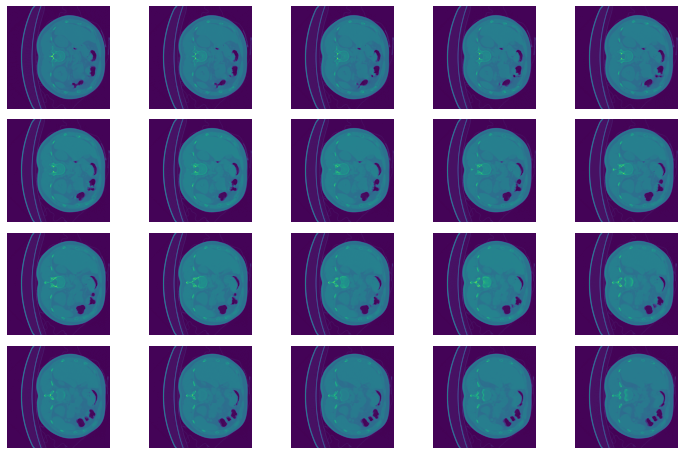

In [ ]:
import matplotlib.pyplot as plt
im_fdata=img.get_fdata()

plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(20):
    plt.subplot(5, 5, i + 1)

    plt.imshow(im_fdata[:,:,i])
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

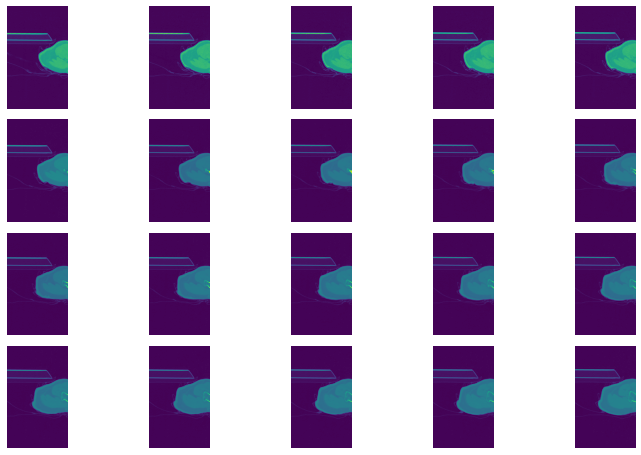

In [ ]:
import matplotlib.pyplot as plt
im_fdata=img.get_fdata()

plt.figure(figsize=(10,8))

# Iterate and plot random images
for i in range(20):
    plt.subplot(5, 5, i + 1)

    plt.imshow(im_fdata[i,:,:])
    plt.axis('off')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()  

In [ ]:
# Read sample
sample_ct = read_nii(data.loc[0,'ct_scan'])

In [ ]:
print (sample_ct.shape)

(512, 512, 301)


## Check HU transform is done or not


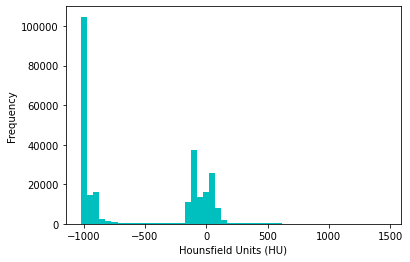

In [ ]:
imgs_to_process = sample_ct[...,1]

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

## No need to transform

In [ ]:
CT = []
Mask = []
img_size = 128


for case in range(len(data)): #Concat all cases to list
    ct = read_nii(data['ct_scan'][case])
    mask = read_nii(data['infection_mask'][case])
    
    for imgsize in range(ct.shape[2]): #Convert pixals to 1-d array
        
        ct_img = cv2.resize(ct[..., imgsize], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        mask_img = cv2.resize(mask[..., imgsize],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        CT.append(ct_img[..., np.newaxis])
        Mask.append(mask_img[..., np.newaxis])

In [ ]:
CT = np.array(CT)
Mask = np.array(Mask)

Text(0.5, 1.0, 'original infection mask')

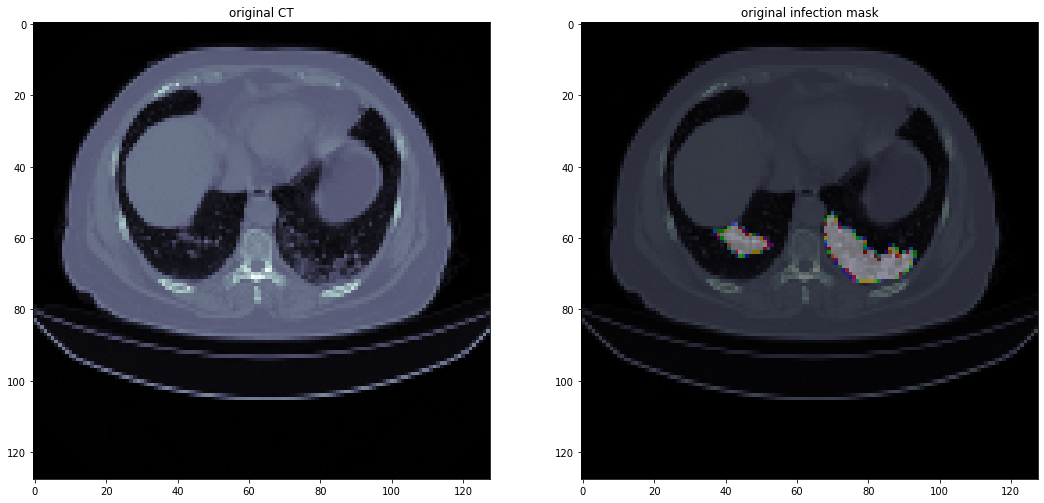

In [ ]:
fig = plt.figure(figsize = (18,15))

plt.subplot(1,2,1)
plt.imshow(CT[100][...,0], cmap = 'bone')
plt.title('original CT')

plt.subplot(1,2,2)
plt.imshow(CT[100][...,0], cmap = 'bone')
plt.imshow(Mask[100][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

## Now we have two choices, we could take lungs mask from CT as input or just use CT images

This time I choose using CT directly

Normalize pixel values in range [0,1] is a good idea before training

In [ ]:
mins = CT.min(axis=(1,2,3), keepdims=True)
maxs = CT.max(axis=(1,2,3), keepdims=True)
norm_data = (CT-mins)/(maxs-mins)

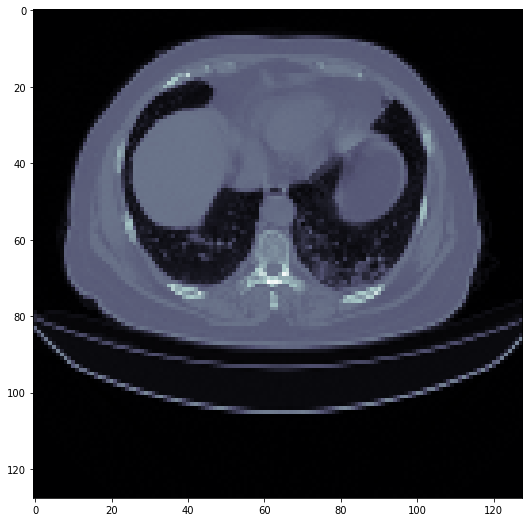

In [ ]:
plt.figure(figsize = (9,9))

plt.imshow(norm_data[100][...,0], cmap = 'bone')

## Split into training and validation groups

In [ ]:
from sklearn.model_selection import train_test_split
CT_train, CT_test, Mask_train, Mask_test = train_test_split(norm_data, Mask, test_size = 0.1)

In [69]:
CT_train.shape

(3168, 128, 128, 1)

In [70]:
CT_test.shape

(352, 128, 128, 1)

In [71]:
Mask_train.shape

(3168, 128, 128, 1)

In [72]:
Mask_test.shape

(352, 128, 128, 1)

## Build Attention resnet
Here we use a slight deviation on the resnet standard

In [85]:
class attention_unet():
  def __init__(self,img_rows=128,img_cols=128, backbone='resnet50'):
    self.img_rows=img_rows
    self.img_cols=img_cols
    self.img_shape=(self.img_rows,self.img_cols,1)
    self.df=64
    self.uf=64
    self.backbone = backbone
    
  def build_unet(self, backbone):
    def conv2d(layer_input,filters,dropout_rate=0,bn=False):
      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(layer_input)
      if bn:
        d=layers.BatchNormalization()(d)
      d=layers.Activation('relu')(d)
      
      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(d)
      if bn:
        d=layers.BatchNormalization()(d)
      d=layers.Activation('relu')(d)
      
      if dropout_rate:
        d=layers.Dropout(dropout_rate)(d)
      
      return d
    
    def deconv2d(layer_input,filters,bn=False):
      u=layers.UpSampling2D((2,2))(layer_input)
      u=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(u)
      if bn:
        u=layers.BatchNormalization()(u)
      u=layers.Activation('relu')(u)
      
      return u
    
    def attention_block(F_g,F_l,F_int,bn=False):
      g=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_g)
      if bn:
        g=layers.BatchNormalization()(g)
      x=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_l)
      if bn:
        x=layers.BatchNormalization()(x)

      psi=layers.Add()([g,x])
      psi=layers.Activation('relu')(psi)
      
      psi=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi)
      
      if bn:
        psi=layers.BatchNormalization()(psi)
      psi=layers.Activation('sigmoid')(psi)
      
      return layers.Multiply()([F_l,psi])
    
    inputs=layers.Input(shape=self.img_shape)
    
    conv1=conv2d(inputs,self.df)
    pool1=layers.MaxPooling2D((2,2))(conv1)
    
    conv2=conv2d(pool1,self.df*2,bn=True)
    pool2=layers.MaxPooling2D((2,2))(conv2)
    
    conv3=conv2d(pool2,self.df*4,bn=True)
    pool3=layers.MaxPooling2D((2,2))(conv3)
    
    conv4=conv2d(pool3,self.df*8,dropout_rate=0.5,bn=True)
    pool4=layers.MaxPooling2D((2,2))(conv4)
    
    conv5=conv2d(pool4,self.df*16,dropout_rate=0.5,bn=True)
    
    up6=deconv2d(conv5,self.uf*8,bn=True)
    conv6=attention_block(up6,conv4,self.uf*8,bn=True)
    up6=layers.Concatenate()([up6,conv6])
    conv6=conv2d(up6,self.uf*8)
    
    up7=deconv2d(conv6,self.uf*4,bn=True)
    conv7=attention_block(up7,conv3,self.uf*4,bn=True)
    up7=layers.Concatenate()([up7,conv7])
    conv7=conv2d(up7,self.uf*4)
    
    up8=deconv2d(conv7,self.uf*2,bn=True)
    conv8=attention_block(up8,conv2,self.uf*2,bn=True)
    up8=layers.Concatenate()([up8,conv8])
    conv8=conv2d(up8,self.uf*2)
    
    up9=deconv2d(conv8,self.uf,bn=True)
    conv9=attention_block(up9,conv1,self.uf,bn=True)
    up9=layers.Concatenate()([up9,conv9])
    conv9=conv2d(up9,self.uf)
    
    outputs=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(conv9)
    
    model=Model(inputs=inputs,outputs=outputs)
    
    return model


from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_model.model", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

## Define BatchNormalization

In [86]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
# import keras.layers as layers
# from keras.models import Model
import tensorflow.keras.layers as layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense


# batchnormalization
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
# block
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x
# residual_block
def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x


## Loss functions

In [87]:
from tensorflow.keras.losses import binary_crossentropy
# from keras import backend as K
import tensorflow.keras.backend as K


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [88]:
from tensorflow.keras.optimizers import Adam

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

## Implement of "Boundary loss for highly unbalanced segmentation"

In [89]:
from scipy.ndimage import distance_transform_edt as distance


def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.numpy().astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    y_true_numpy = y_true
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)


def surface_loss_keras(y_true, y_pred):
    y_true_dist_map = tf.py_function(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

In [90]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback


class AlphaScheduler(Callback):
  def init(self, alpha, update_fn):
    self.alpha = alpha
    self.update_fn = update_fn
  def on_epoch_end(self, epoch, logs=None):
    updated_alpha = self.update_fn(K.get_value(self.alpha))

alpha = K.variable(1, dtype='float32')

def update_alpha(value):
  return np.clip(value - 0.01, 0.01, 1)

## Define Loss function
We should considering both boundary loss and weighted binary cross entropy dice loss


In [91]:
def gl_sl_wrapper(alpha):
    def gl_sl(y_true, y_pred):
        return alpha* weighted_bce_dice_loss(y_true, y_pred) +  (1-alpha)* surface_loss_keras(y_true, y_pred)
    return gl_sl

## Set Training Check Point

In [92]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="Resnet_{}_weights.best.hdf5".format('model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=5) # probably needs to be more patient
callbacks_list = [checkpoint, early, reduceLROnPlat]

## Compile Resnet model

In [93]:
ResNet = attention_unet()
resnet = ResNet.build_unet(backbone='resnet50')

resnet.compile(loss=gl_sl_wrapper(alpha),
             optimizer=Adam(1e-4),
             metrics=[dice_coef, 'binary_accuracy'])

resnet.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 128, 128, 64) 640         input_5[0][0]                    
__________________________________________________________________________________________________
activation_120 (Activation)     (None, 128, 128, 64) 0           conv2d_140[0][0]                 
__________________________________________________________________________________________________
conv2d_141 (Conv2D)             (None, 128, 128, 64) 36928       activation_120[0][0]             
____________________________________________________________________________________________

## Start Training

In [94]:
CT_train.shape

(3168, 128, 128, 1)

In [95]:
Mask_train.shape

(3168, 128, 128, 1)

In [96]:
history = resnet.fit(CT_train, Mask_train, epochs = 10, validation_data = (CT_test, Mask_test),verbose=1,shuffle=True, callbacks=[checkpoint])

Epoch 1/10
99/99 [==============================] - 141s 1s/step - loss: 1.0872 - dice_coef: 0.0905 - binary_accuracy: 0.9166 - val_loss: 1.1057 - val_dice_coef: 0.0093 - val_binary_accuracy: 0.9886

Epoch 00001: val_dice_coef improved from -inf to 0.00935, saving model to Resnet_model_weights.best.hdf5
Epoch 2/10
99/99 [==============================] - 135s 1s/step - loss: 0.4034 - dice_coef: 0.5189 - binary_accuracy: 0.9920 - val_loss: 1.1727 - val_dice_coef: 0.1130 - val_binary_accuracy: 0.9886

Epoch 00002: val_dice_coef improved from 0.00935 to 0.11302, saving model to Resnet_model_weights.best.hdf5
Epoch 3/10
99/99 [==============================] - 135s 1s/step - loss: 0.2972 - dice_coef: 0.6658 - binary_accuracy: 0.9938 - val_loss: 1.1618 - val_dice_coef: 0.2222 - val_binary_accuracy: 0.9886

Epoch 00003: val_dice_coef improved from 0.11302 to 0.22220, saving model to Resnet_model_weights.best.hdf5
Epoch 4/10
99/99 [==============================] - 135s 1s/step - loss: 0.2530

## ResNet-  Plot loss history

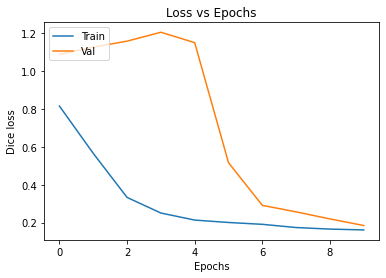

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice loss')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

## ResNet- Run The Test Data To Check Our Predictions

Text(0.5, 1.0, 'predicted infection mask')

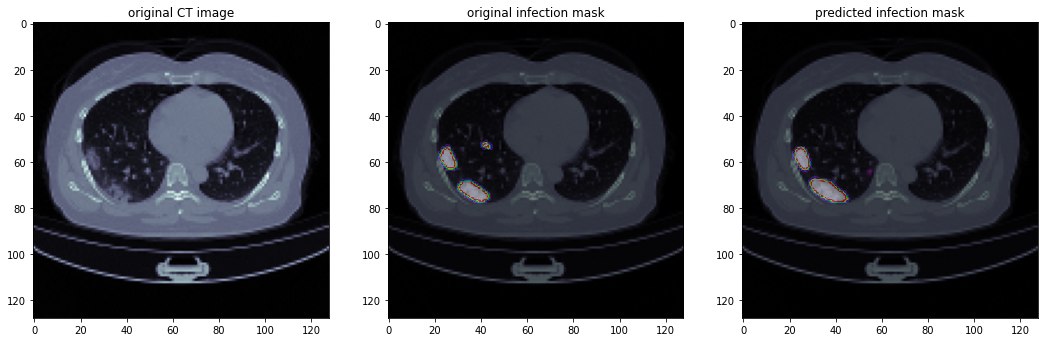

In [ ]:
predicted = resnet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[140][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[140][...,0], cmap = 'bone')
plt.imshow(Mask_test[140][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[140][...,0], cmap = 'bone')
plt.imshow(predicted[140][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

Text(0.5, 1.0, 'predicted infection mask')

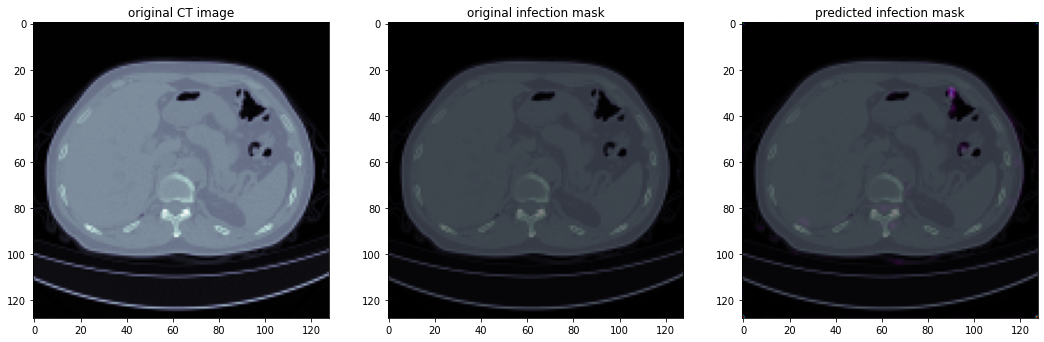

In [100]:
predicted = resnet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[150][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[150][...,0], cmap = 'bone')
plt.imshow(Mask_test[150][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[150][...,0], cmap = 'bone')
plt.imshow(predicted[150][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

Text(0.5, 1.0, 'predicted infection mask')

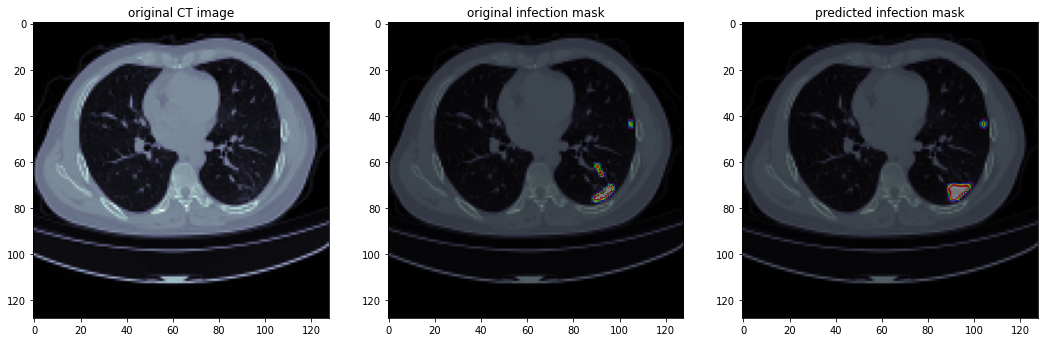

In [101]:
predicted = resnet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[160][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[160][...,0], cmap = 'bone')
plt.imshow(Mask_test[160][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[160][...,0], cmap = 'bone')
plt.imshow(predicted[160][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

## MaskNet Model Implementation

In [97]:
weight_path="MaskNet_{}_weights.best.hdf5".format('model')

MaskNet = attention_unet()
masknet = MaskNet.build_unet(backbone='masknet')

masknet.compile(loss=gl_sl_wrapper(alpha),
             optimizer=Adam(1e-4),
             metrics=[dice_coef, 'binary_accuracy'])

masknet.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_175 (Conv2D)             (None, 128, 128, 64) 640         input_6[0][0]                    
__________________________________________________________________________________________________
activation_150 (Activation)     (None, 128, 128, 64) 0           conv2d_175[0][0]                 
__________________________________________________________________________________________________
conv2d_176 (Conv2D)             (None, 128, 128, 64) 36928       activation_150[0][0]             
____________________________________________________________________________________________

In [98]:
history = masknet.fit(CT_train, Mask_train, epochs = 5, validation_data = (CT_test, Mask_test),verbose=1,shuffle=True, callbacks=[checkpoint])

Epoch 1/5
99/99 [==============================] - 141s 1s/step - loss: 1.0666 - dice_coef: 0.0937 - binary_accuracy: 0.9241 - val_loss: 1.0912 - val_dice_coef: 0.0082 - val_binary_accuracy: 0.9886

Epoch 00001: val_dice_coef did not improve from 0.80295
Epoch 2/5
99/99 [==============================] - 135s 1s/step - loss: 0.3764 - dice_coef: 0.5204 - binary_accuracy: 0.9926 - val_loss: 1.1219 - val_dice_coef: 0.0213 - val_binary_accuracy: 0.9886

Epoch 00002: val_dice_coef did not improve from 0.80295
Epoch 3/5
99/99 [==============================] - 135s 1s/step - loss: 0.2821 - dice_coef: 0.6619 - binary_accuracy: 0.9940 - val_loss: 1.1511 - val_dice_coef: 0.0888 - val_binary_accuracy: 0.9886

Epoch 00003: val_dice_coef did not improve from 0.80295
Epoch 4/5
99/99 [==============================] - 135s 1s/step - loss: 0.2546 - dice_coef: 0.7127 - binary_accuracy: 0.9945 - val_loss: 1.1723 - val_dice_coef: 0.1944 - val_binary_accuracy: 0.9885

Epoch 00004: val_dice_coef did not i

In [102]:
masknet.load_weights('model_weights.best.hdf5')
masknet.save('model.h5')

## MaskNet- Plot loss history

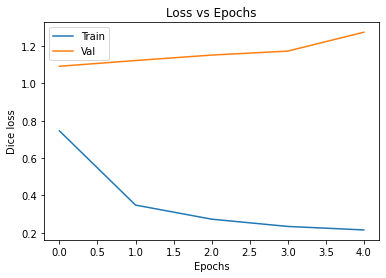

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice loss')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

## MaskNet- Run The Test Data To Check Our Predictions

Text(0.5, 1.0, 'predicted infection mask')

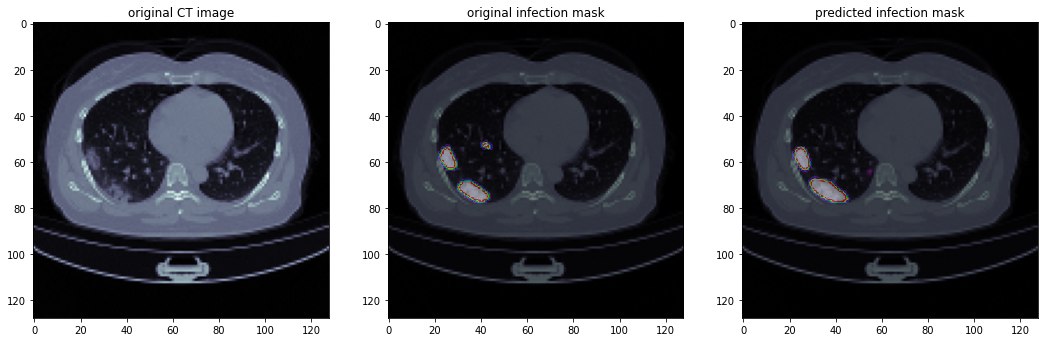

In [104]:
predicted = masknet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[140][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[140][...,0], cmap = 'bone')
plt.imshow(Mask_test[140][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[140][...,0], cmap = 'bone')
plt.imshow(predicted[140][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

Text(0.5, 1.0, 'predicted infection mask')

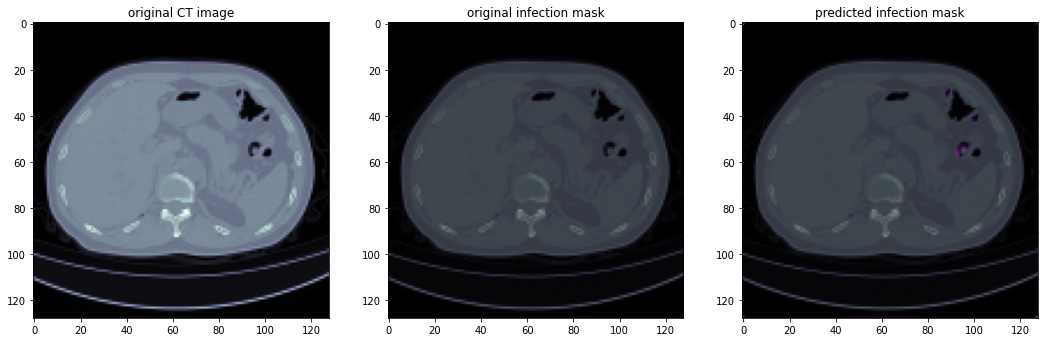

In [105]:
predicted = masknet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[150][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[150][...,0], cmap = 'bone')
plt.imshow(Mask_test[150][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[150][...,0], cmap = 'bone')
plt.imshow(predicted[150][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

Text(0.5, 1.0, 'predicted infection mask')

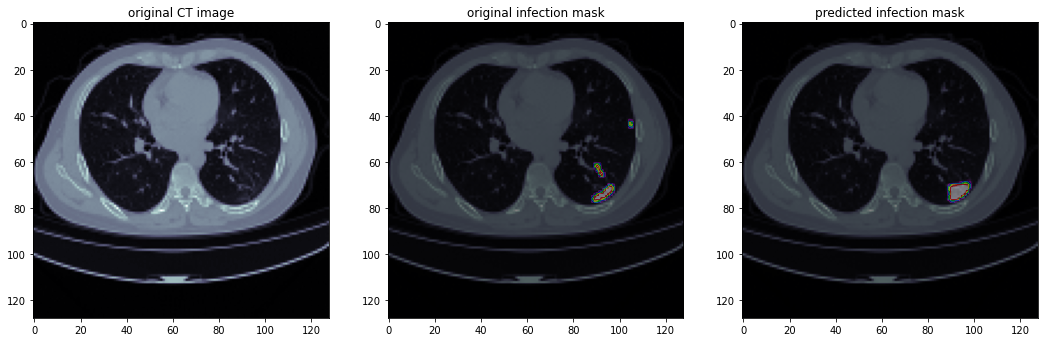

In [106]:
predicted = masknet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[160][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[160][...,0], cmap = 'bone')
plt.imshow(Mask_test[160][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[160][...,0], cmap = 'bone')
plt.imshow(predicted[160][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')